## **Do NOT touch this cell**

In [1]:
!wget http://www-prima.inrialpes.fr/perso/Gourier/Faces/HeadPoseImageDatabase.tar.gz
!tar -xvzf HeadPoseImageDatabase.tar.gz

from google.colab import output
output.clear()

import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
import torch.utils as utils
from google.colab.patches import cv2_imshow
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

person_list = sorted(glob.glob('Person*')) # search the folders starting with 'Person'

img_list = []
train_img_list = []
val_img_list = []
test_img_list = []
H = 288
W = 384



## **You can change the list of training and validation persons**

In [2]:
# Train & Validation Select
train_person = [0,2,4,6,8]
val_person = [1,3,5,7,9]

##**Do NOT touch this cell**

In [3]:
test_person = [10,11,12,13,14]

for i in range(len(person_list)):
    if i in train_person:
        train_img_list.extend(glob.glob(os.path.join(person_list[i], '*.jpg')))
    if i in test_person: 
        test_img_list.extend(glob.glob(os.path.join(person_list[i], '*.jpg')))
    if i in val_person:
        val_img_list.extend(glob.glob(os.path.join(person_list[i], '*.jpg'))) 

## **You can change Transform.Compose (Data Augmentation)**

In [4]:
# Transformation with data augmentation
image_train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5612, 0.5684, 0.5908),(0.2566,0.2496, 0.2446)),     
])

image_test_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5612, 0.5684, 0.5908),(0.2566,0.2496, 0.2446)),     
])

image_inverse_transform = transforms.Compose([
                                              transforms.Normalize((-2.1868,-2.2768,-2.4146),(3.8966,4.0052,4.0869)),
])


## **Do NOT touch this cell**

               ( X,   Y)
Top Left     : (  7,170)
Bottom Right : ( 85,270)


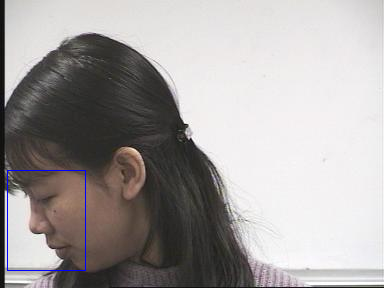

In [5]:
############################################################################
#
#                   Data set and dataloader
#
############################################################################

class custom_dataset():
    def __init__(self, img_list, is_train):
        self.img_list = img_list
        self.is_train = is_train
        
    def __getitem__(self,index):
        img_file = self.img_list[index]

        image = cv2.imread(img_file) # read the image file
        image = Image.fromarray(image)
        txt_file = img_file[:-4] + '.txt' # take the txt file address from the image file address
        with open(txt_file,'r') as f:
            line = f.read().splitlines()
            center_x = int(line[3])/W
            center_y = int(line[4])/H
            width = int(line[5])/W
            height = int(line[6])/H # open the text file and take the face box information from it
        if self.is_train:
            image = image_train_transform(image)
        else:
            image = image_test_transform(image)
        label = torch.tensor([center_x, center_y, width, height])

        return image, label
        
    def __len__(self):
        return len(self.img_list)

train_datasets = custom_dataset(train_img_list, is_train=True)
val_datasets = custom_dataset(val_img_list, is_train=False)
test_datasets = custom_dataset(test_img_list, is_train=False)

trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=8, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_datasets, batch_size=8, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=False, num_workers=2)


############################################################################
#
#                   Sample visualization
#
############################################################################

sample_image, sample_label = next(iter(trainloader))

sample_image = sample_image[0]
sample_label = sample_label[0]

sample_image = image_inverse_transform(sample_image)

sample_cx = sample_label[0] * W
sample_cy = sample_label[1]* H
sample_w = sample_label[2]* W
sample_h = sample_label[3] * H

# calculate the left-top & right-down coordinates from the box info( x, y, w, h)
sample_x1 = int(sample_cx - sample_w//2)
sample_y1 = int(sample_cy - sample_h//2)
sample_x2 = int(sample_cx + sample_w//2)
sample_y2 = int(sample_cy + sample_h//2) 

sample_image = sample_image.numpy().transpose(1,2,0) * 255
print('               ( X,   Y)')
print('Top Left     : (%3d,%3d)'%(sample_x1,sample_y1))
print('Bottom Right : (%3d,%3d)'%(sample_x2,sample_y2))

sample_image = cv2.rectangle(sample_image, (sample_x1, sample_y1), (sample_x2,sample_y2), (255,0,0), (1)) # draw blue rectangle on the image
sample_image = cv2.UMat.get(sample_image)

cv2_imshow(sample_image) # print the image

## **You have to make your own network. Or, you can fit a well-known network to our data.**

In [6]:
class FaceNet(nn.Module):
    def __init__(self):
        super(FaceNet, self).__init__()
        self.features = nn.Sequential(
            #64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),            
            #64
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #M
            nn.MaxPool2d(kernel_size=2, stride=2),
            #128
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            #128
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            #M
            nn.MaxPool2d(kernel_size=2, stride=2),
            #256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #256
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #M
            nn.MaxPool2d(kernel_size=2, stride=2),
            #512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #M
            nn.MaxPool2d(kernel_size=2, stride=2),
            #512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #M
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AvgPool2d(kernel_size=1, stride=1),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

print('Building Network!')
net = FaceNet()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.0004, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(),lr=0.00015)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

epochs = 200

def train(epoch):
    print('\nTrain:')
    net.train()
    train_loss = 0
    for batch_idx, (images, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if ((batch_idx+1) % (len(trainloader)/3) == 1) or batch_idx+ 1 == len(trainloader):
            print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(trainloader), train_loss/(batch_idx+1)))
    # print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(trainloader), train_loss/(batch_idx+1)))

def val(epoch):
    print('\nValidation:')
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valloader):
            
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            if ((batch_idx+1) % (len(valloader)/3) == 1) or batch_idx+ 1 == len(valloader):
                print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(valloader), val_loss/(batch_idx+1)))
        # print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(valloader), val_loss/(batch_idx+1)))
    scheduler.step()

for epoch in range(epochs):
    print('\nEpoch %d'%(epoch))
    train(epoch)
    val(epoch)

Building Network!

Epoch 0

Train:
[  1/117] | Loss: 0.13273
[ 40/117] | Loss: 0.01622
[ 79/117] | Loss: 0.01301
[117/117] | Loss: 0.01090

Validation:
[  1/117] | Loss: 0.02480
[ 40/117] | Loss: 0.01820
[ 79/117] | Loss: 0.01326
[117/117] | Loss: 0.01151

Epoch 1

Train:
[  1/117] | Loss: 0.00396
[ 40/117] | Loss: 0.00425
[ 79/117] | Loss: 0.00412
[117/117] | Loss: 0.00432

Validation:
[  1/117] | Loss: 0.01336
[ 40/117] | Loss: 0.01225
[ 79/117] | Loss: 0.00999
[117/117] | Loss: 0.00913

Epoch 2

Train:
[  1/117] | Loss: 0.00262
[ 40/117] | Loss: 0.00361
[ 79/117] | Loss: 0.00332
[117/117] | Loss: 0.00326

Validation:
[  1/117] | Loss: 0.01200
[ 40/117] | Loss: 0.01358
[ 79/117] | Loss: 0.01155
[117/117] | Loss: 0.01130

Epoch 3

Train:
[  1/117] | Loss: 0.00380
[ 40/117] | Loss: 0.00308
[ 79/117] | Loss: 0.00314
[117/117] | Loss: 0.00323

Validation:
[  1/117] | Loss: 0.01041
[ 40/117] | Loss: 0.01042
[ 79/117] | Loss: 0.00927
[117/117] | Loss: 0.00894

Epoch 4

Train:
[  1/117] | L

##**Do NOT touch this cell**


Test:
[930/930] | final_MSE: 0.001088
[GT □] | [Pred □]


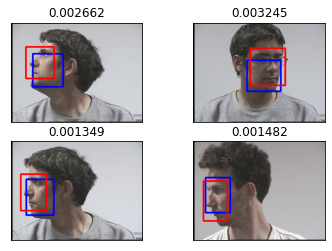

In [7]:
fig = plt.figure()

visualize_idx = np.random.randint(len(testloader), size=4)
cnt = 0
test_loss = 0


with torch.no_grad():
    print('\nTest:')
    net.eval()
    for batch_idx, (images, labels) in enumerate(testloader):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        if batch_idx+1 == len(testloader):
            print('[%3d/%3d] | final_MSE: %f'%(batch_idx+1, len(testloader), test_loss/(batch_idx+1)))
            print('\033[31m' + '[GT □]' + '\033[30m' +' | ' + '\033[34m' +'[Pred □]' +  '\033[0m')
        if batch_idx in visualize_idx: # visualize for selected images
            subplot = fig.add_subplot(2,2, cnt+1)    

            sample_image = images[0]
            sample_outputs = outputs[0]
            sample_label = labels[0]

            sample_image = image_inverse_transform(sample_image)
            sample_image = sample_image.cpu().numpy().transpose(1,2,0) * 255
            
            # Draw for predicted box
            sample_cx = sample_outputs[0] * W
            sample_cy = sample_outputs[1] * H
            sample_w = sample_outputs[2] * W
            sample_h = sample_outputs[3] * H

            sample_x1 = int(sample_cx - sample_w//2)
            sample_y1 = int(sample_cy - sample_h//2)
            sample_x2 = int(sample_cx + sample_w//2)
            sample_y2 = int(sample_cy + sample_h//2)
            
            sample_image = cv2.rectangle(sample_image, (sample_x1, sample_y1), (sample_x2, sample_y2), (255, 0, 0), (3))
            sample_image = cv2.UMat.get(sample_image)
            
            # Draw for groundtruth box
            sample_cx = sample_label[0] * W
            sample_cy = sample_label[1] * H
            sample_w = sample_label[2] * W
            sample_h = sample_label[3] * H

            sample_x1 = int(sample_cx - sample_w//2)
            sample_y1 = int(sample_cy - sample_h//2)
            sample_x2 = int(sample_cx + sample_w//2)
            sample_y2 = int(sample_cy + sample_h//2)
            
            sample_image = cv2.rectangle(sample_image, (sample_x1, sample_y1), (sample_x2, sample_y2), (0, 0, 255), (3))
            
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.set_title('%f'%loss.item())
            subplot.imshow(cv2.cvtColor(sample_image.astype('uint8'), cv2.COLOR_BGR2RGB))           
            cnt += 1

plt.show()